In [2]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [1]:
import torch
torch.__version__

'2.2.0+cu121'

## Foreground method

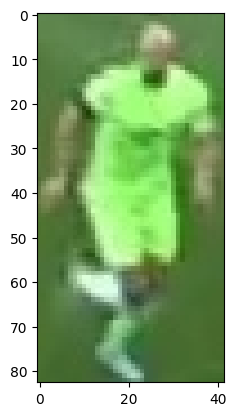

In [10]:
img = cv2.imread('../photos/croppedimg.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

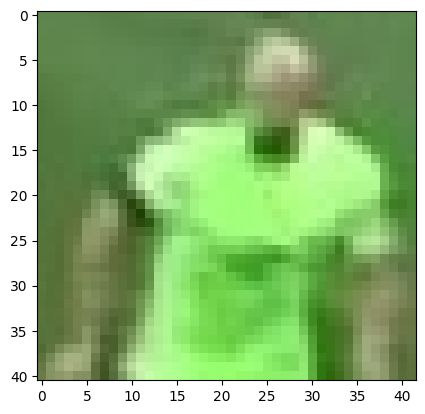

In [11]:
top_half_img = img[0:img.shape[0]//2, 0:img.shape[1]]
plt.imshow(top_half_img)

In [32]:
image_2d = top_half_img.reshape(-1, 3)
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=1)
kmeans.fit(image_2d)

labels = kmeans.labels_
center_clusters = kmeans.cluster_centers_

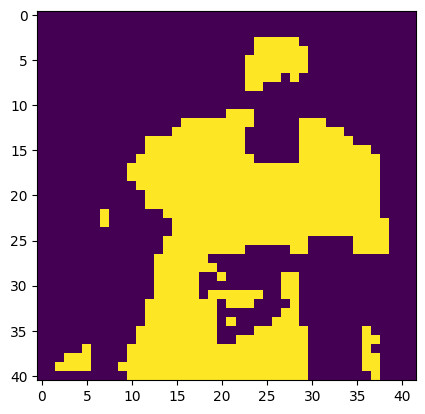

In [33]:
# show the image after clustering
clustred_image = labels.reshape(top_half_img.shape[0], top_half_img.shape[1])
plt.imshow(clustred_image)

In [34]:
corner_cluster = [clustred_image[0,0], clustred_image[0,-1], clustred_image[-1,0], clustred_image[-1,-1]]
corner_cluster
non_player = max(set(corner_cluster), key=corner_cluster.count)
player = 1 - non_player
player

1

In [35]:
center_clusters[player]

array([159.12014134, 229.56713781, 126.9664311 ])

## Center-Box method

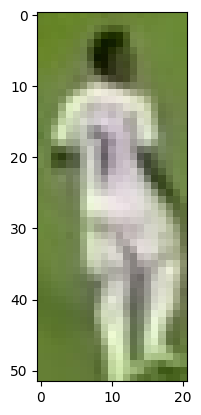

In [37]:
img = cv2.imread('../photos/players_frame.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [38]:
img.shape

(52, 21, 3)

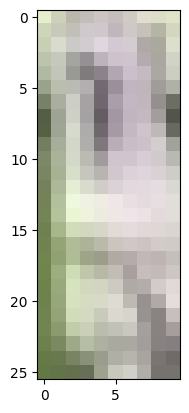

In [39]:
image_center_box = img[img.shape[0]//4:3*img.shape[0]//4, img.shape[1]//4:3*img.shape[1]//4]
plt.imshow(image_center_box)

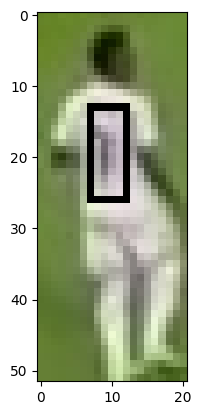

In [40]:
img2 = img.copy()
cv2.rectangle(img2, (img2.shape[1]//3, img2.shape[0]//4), (3*img2.shape[1]//5, 2*img2.shape[0]//4), (0, 0, 0), 1)
plt.imshow(img2)

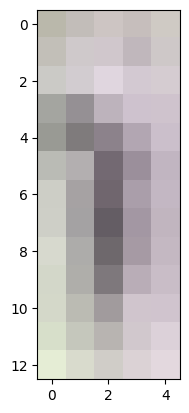

In [41]:
img_cropped = img[img2.shape[0]//4:(2*img2.shape[0])//4, img2.shape[1]//3:(3*img2.shape[1])//5]

plt.imshow(img_cropped)

In [42]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=1)
kmeans.fit(img_cropped.reshape(-1, 3))

labels = kmeans.labels_
center_clusters = kmeans.cluster_centers_

<BarContainer object of 5 artists>

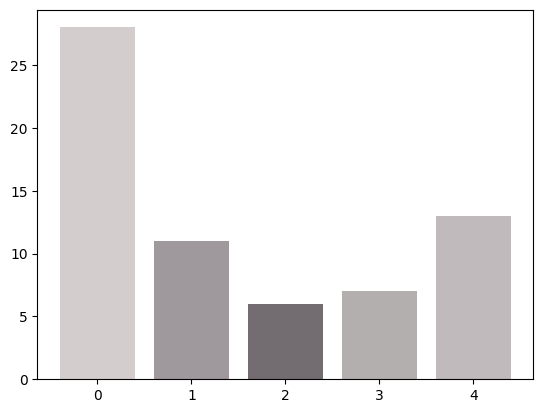

In [43]:
plt.bar(range(5), [sum(labels==i) for i in range(5)], color=[center_clusters[i]/255 for i in range(5)])

In [51]:
# get the avrage color of high two clusters
player_color = center_clusters[np.argsort([sum(labels==i) for i in range(5)])]
# take avrage of the two highest clusters
player_color = np.mean(player_color[:2], axis=0)
player_color

array([147.5       , 141.3452381 , 144.16666667])

In [50]:
max_color = center_clusters[np.argmax([sum(labels==i) for i in range(5)])]
max_color

array([211.39285714, 206.32142857, 205.46428571])

## siglip method (embedding)

In [2]:
import torch
from transformers import AutoProcessor, SiglipVisionModel
from tqdm import tqdm
import supervision as sv
from ultralytics import YOLO
import cv2 

c:\Users\Yousef\anaconda3\envs\YOLO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_path = '../models/tuned/best-tuned.pt'
model = YOLO(model_path)

In [4]:
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

In [5]:
def detect_frames(frames):
    batch_size = 20  # number of frames to process at once 
    detections = []

    for i in range(0, len(frames), batch_size):
        # Perform model prediction on the batch
        batch_results = model.predict(frames[i:i+batch_size], conf=0.1, device='cuda:0', verbose=False)
        
        # Ensure batch_results is a list, process each result individually
        for result in batch_results:
            # Convert result to Detections object
            detection = sv.Detections.from_ultralytics(result)
            detections.append(detection)
    
    return detections

In [6]:
def detect_frames(frames):
    batch_size = 20  # number of frames to process at once 
    all_batch_results = []

    for i in range(0, len(frames), batch_size):
        # Perform model prediction on the batch
        batch_results = model.predict(frames[i:i+batch_size], conf=0.1, device='cuda:0', verbose=False)
        all_batch_results.extend(batch_results)
    
    return all_batch_results


In [7]:
def convert_to_detections(batch_results):
    detections = []
    for result in batch_results:
        # Convert result to Detections object
        detection = sv.Detections.from_ultralytics(result)
        detections.append(detection)
    return detections


In [8]:
frames = read_video('../input_videos/vini.mp4')
PLAYER_ID = 2
crops = []

# Step 1: Detect frames and get batch results
batch_results = detect_frames(frames)

# Step 2: Convert batch results to Detections objects
detections = convert_to_detections(batch_results)

# Step 3: Process each frame and its corresponding detections
for frame, detection in tqdm(zip(frames, detections), desc='collecting crops'):
    # Filter detections by the class ID (e.g., PLAYER_ID)
    player_detections = detection[detection.class_id == PLAYER_ID]
    
    # Crop images for each player detected in the frame
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
    
    # Collect all crops
    crops += players_crops


collecting crops: 501it [00:00, 13102.95it/s]


In [18]:
len(detections)

501

In [50]:
frames = read_video('../input_videos/passing.mp4')
PLAYER_ID = 2
crops = []

# Process each frame and its corresponding detections
for frame, detection in tqdm(zip(frames, detect_frames(frames)), desc='collecting crops'):
    # Filter detections by the class ID (e.g., PLAYER_ID)
    player_detections = detection[detection.class_id == PLAYER_ID]
    
    # Crop images for each player detected in the frame
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in player_detections.xyxy]
    
    # Collect all crops
    crops += players_crops


collecting crops: 1378it [00:00, 11427.29it/s]


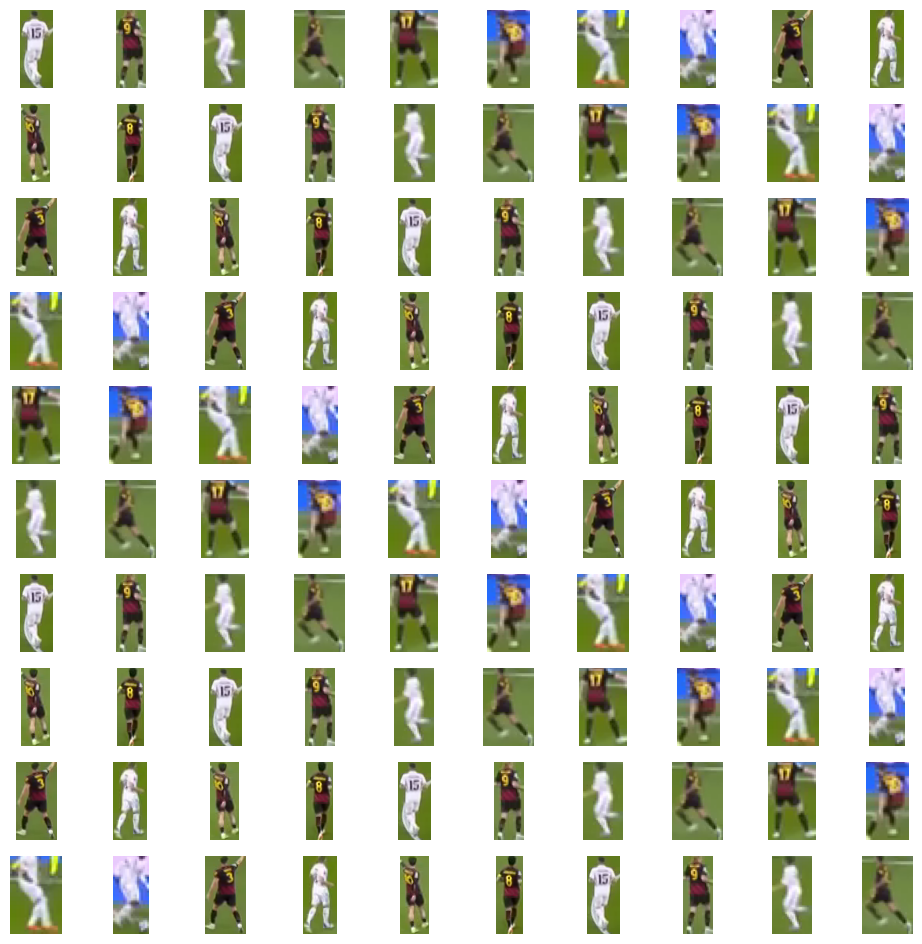

In [9]:
sv.plot_images_grid(crops[100:200], grid_size=(10, 10))

In [10]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

In [11]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

# crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 0it [00:00, ?it/s]c:\Users\Yousef\anaconda3\envs\YOLO\Lib\site-packages\transformers\models\siglip\modeling_siglip.py:573: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
embedding extraction: 136it [01:03,  2.15it/s]


In [12]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [13]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [15]:
len(clusters)

4349

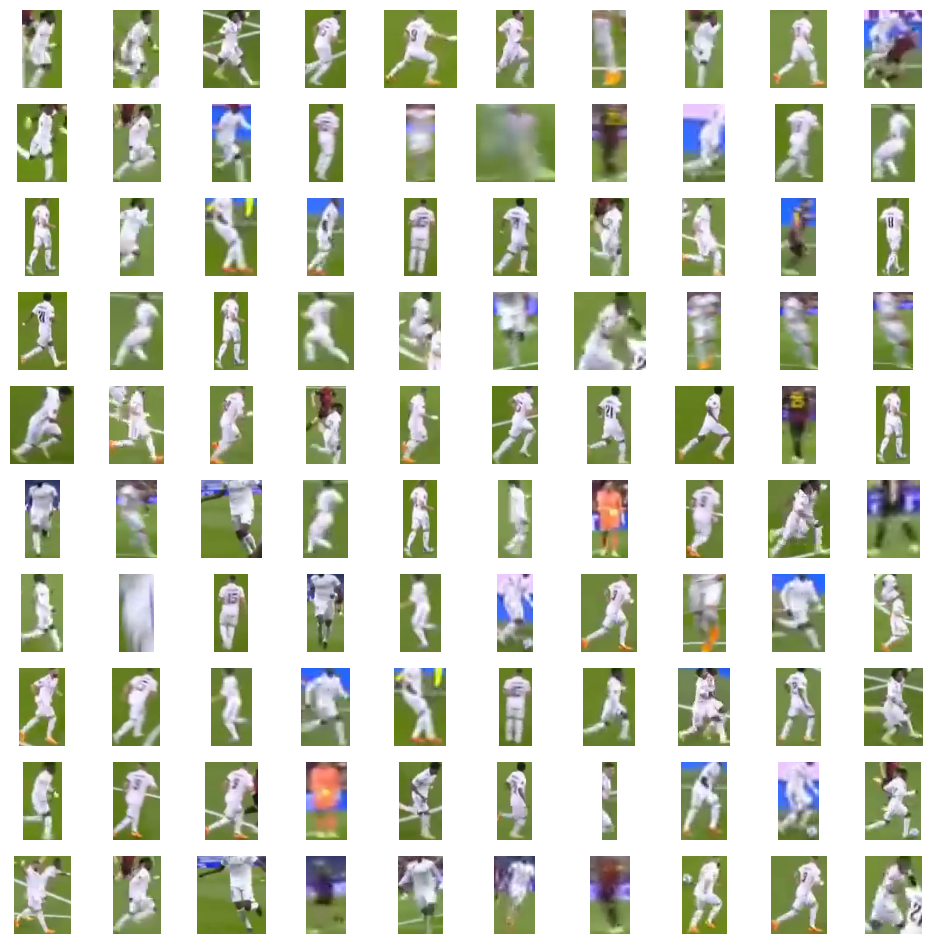

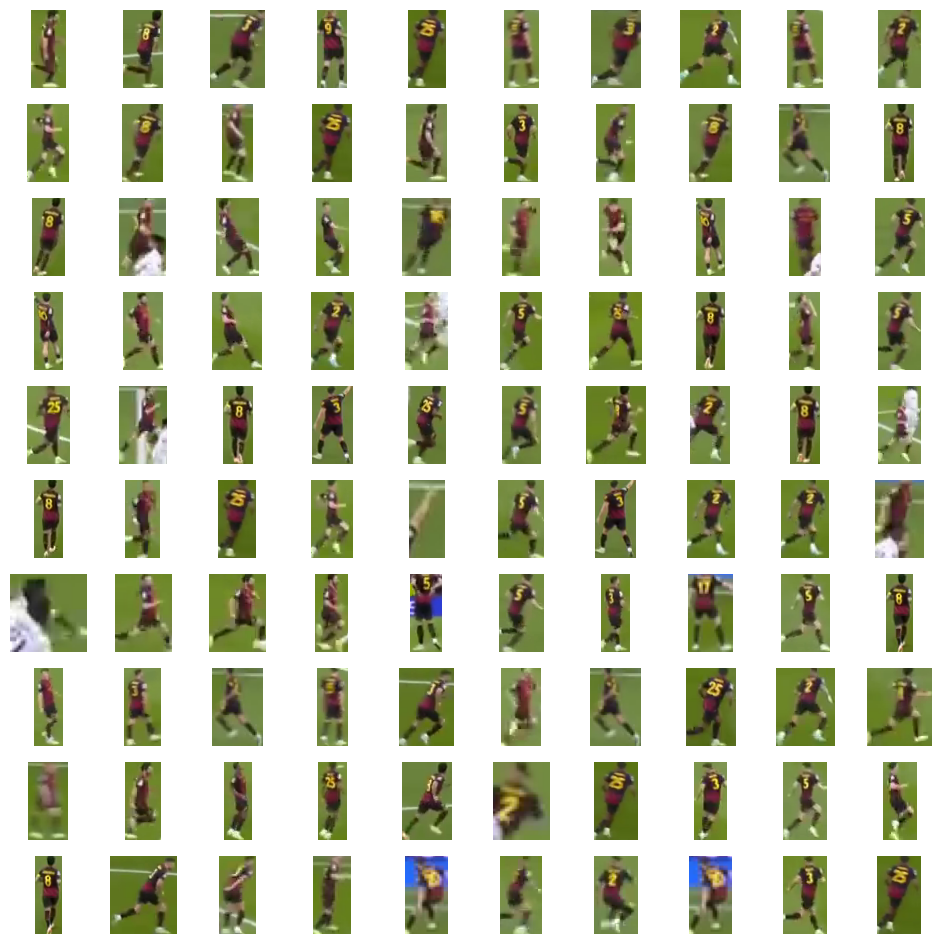

In [16]:
team1 = [crop for crop, cluster in zip(crops, clusters) if cluster == 0]
team2 = [crop for crop, cluster in zip(crops, clusters) if cluster == 1]
## shuffle the crops
rand_list = np.random.randint(0, len(team1), 100)
team1_shuffle = [team1[i] for i in rand_list]
rand_list = np.random.randint(0, len(team2), 100)
team2_shuffle = [team2[i] for i in rand_list]

sv.plot_images_grid(team1_shuffle, grid_size=(10, 10))
sv.plot_images_grid(team2_shuffle, grid_size=(10, 10))